# MASTER FUNCTION
The master function contains all the modules to build a simulation. All of the parameters are pre set for you and change them as you see fit. Below is the function and it's parameters and respective data types.

```python
def master_function(demand=demand,
                    Date='2018-06-11',
                    percentOfPassenger=.309, 
                    percentDropOff=.5,
                    percentPickUp=.5,
                    percentOfTNC=.255,
                    percentOfTaxi=.027,
                    percentOfTransit=.005,
                    percentOfParking=.25,
                    percentOfLimo=.01,
                    percentOfRental=.144,
                    dwell_times=dwell_time,
                    scale = 1,
                    sigma=.5 ):
```

In [1]:
from __future__ import print_function
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, SubElement, Comment
from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime
sys.path.insert(0, os.path.abspath('../Generate_SUMO_demand/'))
import DFW_gen_flow as gf
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import ToggleButtons
import math 
import MasterModule as mm

import warnings
warnings.filterwarnings('ignore')


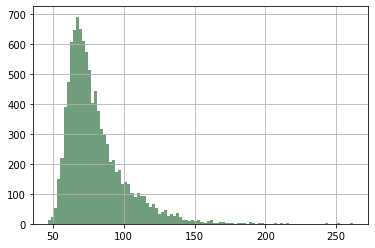

In [2]:
dwell_time = np.random.exponential(20,10000) + np.random.normal(60,5,10000)
demand = pd.read_csv("../Example_Files/athena_sumo_v1.csv")
selected = pd.read_csv("selected_demand.csv",)
plt.hist(dwell_time,bins=100,color='#709e7c')
plt.grid()
plt.show()

In [3]:
selected

,Unnamed: 0,Date,Volume_Category
0,0,2017-10-16,high
1,1,2017-10-28,low
2,2,2017-10-17,medium
3,3,2017-11-22,high
4,4,2017-11-30,medium
5,5,2017-11-24,low
6,6,2017-12-21,high
7,7,2017-12-28,medium
8,8,2017-12-2,low
9,9,2018-1-2,high


In [11]:
def master_function(demand=demand,
                    Date='2018-06-11',
                    percentOfPassenger=.309, 
                    percentDropOff=.5,
                    percentPickUp=.5,
                    percentOfTNC=.255,
                    percentOfTaxi=.027,
                    percentOfTransit=.005,
                    percentOfParking=.25,
                    percentOfLimo=.01,
                    percentOfRental=.144,
                    dwell_times=dwell_time,
                    years = 0,
                    growth = 1.03,
                    capacity = 50, 
                    #CarsToPeople add later
                    peopleToCars = 1.7,
                    peopleToCarsPolicy = 1.7,
                    level = 'high',
                    sigma=.5 #0 is perfect driver and 1 is max imperfection
                   ):
    total = percentOfPassenger + percentOfTNC + percentOfTaxi + percentOfTransit + percentOfParking + percentOfRental + percentOfLimo 
    message = "Mode choices do not sum to 1; Seems to add to " + str(total)
    
    assert total == 1, message
    assert percentDropOff + percentPickUp == 1, "Drop off and Pickup must add to 1"
    # Get date in correct format
    strg = Date.split('-')
    if len(strg[1]) == 2 and strg[1][0] == '0':
        strg[1] = strg[1][1]    
    if len(strg[2]) == 2 and strg[2][0] == '0':
        strg[2] = strg[2][1] 
    Date = "-".join(strg)
    
    
    #1. Split Arrival and Departure
    day = mm.pick_day(demand, Date,level)  
    #2 scale
    day = mm.scale_vehicles(day,years,growth)
    day = mm.distributeParking(day,['A','B','C','D','E'])    
    cars = mm.create_depart_arrive(day,percentDropOff,percentPickUp)
    #2. Convert Vehicles to People    
    people_demand = mm.cars_to_people(cars,peopleToCars)
    #3. Generate Demand for each Mode of Travel
#         a. Passenger
    print("Generating Passenger  Demand")
    print(80*"=")
    mm.create_sumo_demand_passenger_curbside(people_demand,level,Date,percentOfPassenger,peopleToCarsPolicy)
    print("Generating Taxi Demand")
    print(80*"=")
    mm.create_sumo_demand_taxi_curbside(people_demand,level,Date,percentOfTaxi,peopleToCarsPolicy)
    print("Generating TNC Demand")
    print(80*"=")
    mm.create_sumo_demand_TNC_curbside(people_demand,level,Date,percentOfTNC,peopleToCarsPolicy)
    print("Generating Limo Demand")
    print(80*"=")
    mm.create_sumo_demand_limo_curbside(people_demand,level,Date,percentOfLimo,peopleToCarsPolicy)
    print("Generating Parking Demand")
    print(80*"=")
    buses = mm.create_sumo_demand_parking(people_demand,level,Date,percentOfParking,peopleToCarsPolicy)
    mm.add_buses_for_people(buses,Date,level,capacity)
    print("Generating Pass-Thru Demand")
    print(80*"=")
    mm.create_sumo_demand_passthru(people_demand,Date,level)
    
    #4. Combine XML Files
    scaledPercent = round(100*((growth**years)-1))
    if scaledPercent > 0:
        scale = "Scaled" + str(scaledPercent) +"%"
        file_name = Date + '.' + scale +".trips.xml"
    else: 
        file_name = Date + '.' + level +".trips.xml"
    mm.combineTrips(file_name)
    # Clear TMP files
   
    tmp_folder = "../Example_Files/TempDemandXML/"
    files = Date + "*"
    command = "rm " + tmp_folder + files
    os.system(command)
    #5. Move Files to Eagle
        #Note: currently using scp
    #6. Run on Eagle
        #Note: ensure you have Network, Route file, additional file/s
        #also generate some type of output
    #7. Analyis of Outputs
        #a. convert to csv
        

In [14]:
master_function(years = 0)


Generating Passenger  Demand
Saving to xml:  2018-6-11.high.passenger.curb.xml
Generating Taxi Demand
Saving to xml:  2018-6-11.high.taxi.curb.xml
Generating TNC Demand
Saving to xml:  2018-6-11.high.TNC.curb.xml
Generating Limo Demand
Saving to xml:  2018-6-11.high.limo.curb.xml
Generating Parking Demand
Saving to xml:  2018-6-11.high.parking.xml
Saving to xml:  2018-6-11.high.MoreBuses.xml
Generating Pass-Thru Demand
Saving to xml:  2018-6-11.high.passthru.xml
36
Combining:  ../Example_Files/TempDemandXML/2018-6-11.high.parking.xml
Combining:  ../Example_Files/TempDemandXML/2018-6-11.high.passenger.curb.xml
Combining:  ../Example_Files/TempDemandXML/SampleBus.xml
Combining:  ../Example_Files/TempDemandXML/2018-6-11.high.taxi.curb.xml
Combining:  ../Example_Files/TempDemandXML/2018-6-11.high.TNC.curb.xml
Combining:  ../Example_Files/TempDemandXML/2018-6-11.high.MoreBuses.xml
Combining:  ../Example_Files/TempDemandXML/2018-6-11.high.limo.curb.xml
Combining:  ../Example_Files/TempDeman